# Taming the black-box: Creating intelligible boosted trees models

Bring structure into boosted trees models by

1. interaction constraints, and/or
2. monotonic constraints.

<span style="color:darkorange"> **Can decide about usefulness of model!**</span>

We use typical XAI methods for visualizing feature effects (and constraints):

- TreeSHAP, 
- partial dependence plots (PDP), and
- individual conditional expectation (ICE) plots (= disaggregated PDP).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Load data

- Motor third-part liability (MTPL) pricing dataset.
- 1 Mio insurance policies and their corresponding claim counts.
- Will model claim counts (`claim_nb`) as function of all other columns.
- Synthetically generated via Copulas. True model known.
- Available from [this link](https://www.openml.org/search?type=data&status=active&id=45106) on OpenML, or as parquet file in repo.

*Reference*

>Mayer, M., Meier, D. and Wuthrich, M.V. (2023). 
>SHAP for Actuaries: Explain any Model. 
>http://dx.doi.org/10.2139/ssrn.4389797. 

In [31]:
if False:  # Fetch from OpenML
    from sklearn.datasets import fetch_openml
    
    df0 = fetch_openml(data_id=45106, as_frame=True)
    df = df0.data
    df["claim_nb"] = df0.target
else:     # Fetch from repo
    df = pd.read_parquet("df.parquet")
df

,year,town,driver_age,car_weight,car_power,car_age,claim_nb
0,2018.0,1.0,51.0,1760.0,173.0,3.0,0
1,2019.0,1.0,41.0,1760.0,248.0,2.0,0
2,2018.0,1.0,25.0,1240.0,111.0,2.0,0
3,2019.0,0.0,40.0,1010.0,83.0,9.0,0
4,2018.0,0.0,43.0,2180.0,169.0,5.0,0
...,...,...,...,...,...,...,...
999995,2019.0,1.0,45.0,1090.0,62.0,2.0,0
999996,2019.0,1.0,45.0,1180.0,93.0,4.0,0
999997,2018.0,1.0,31.0,1060.0,57.0,1.0,0
999998,2019.0,1.0,28.0,1910.0,149.0,0.0,0


## Describe data

Let's first describe the distribution of each column univariately.

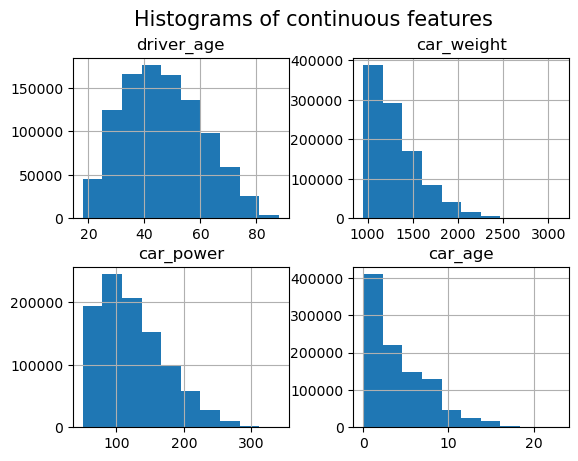

In [34]:
df.hist(["driver_age", "car_weight", "car_power", "car_age"])
_ = plt.suptitle("Histograms of continuous features", fontsize=15)

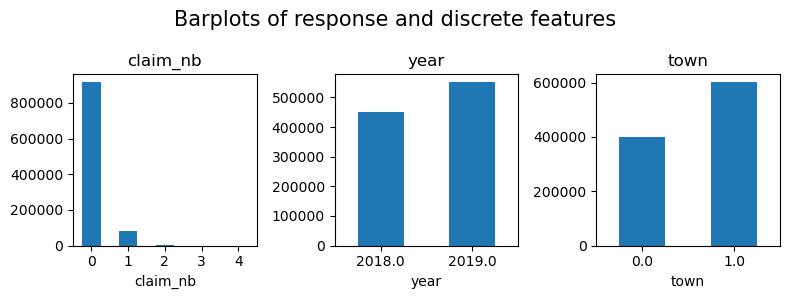

In [36]:
fig, axes = plt.subplots(figsize=(8, 3), ncols=3)

for v, ax in zip(["claim_nb", "year", "town"], axes):
    df[v].value_counts(sort=False).sort_index().plot(kind="bar", ax=ax, rot=0, title=v)
plt.suptitle("Barplots of response and discrete features", fontsize=15)
plt.tight_layout()

## Data split

In [37]:
from sklearn.model_selection import train_test_split

y_train, y_test, X_train, X_test = train_test_split(
    df["claim_nb"], df.drop("claim_nb", axis=1), test_size=0.1, random_state=30
)

## A first model

- LightGBM model using Poisson deviance loss.
- Number of trees via early stopping on CV performance.
- Other parameters manually via CV.

In [38]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

dtrain = lgb.Dataset(X_train, label=y_train)

### Parameter tuning

In [39]:
params = dict(
    learning_rate=0.05,
    objective="poisson",
    metric="poisson",
    num_leaves=7,
    min_child_samples=50,
    min_child_weight=0.001,
    colsample_bynode=0.8,
    subsample=0.8,
    reg_alpha=3,
    reg_lambda=5,
    verbose=-1,
)

if False:  # Set to True to re-run CV
    cvm = lgb.cv(
        params=params,
        train_set=dtrain,
        num_boost_round=2000,
        nfold=5,
        callbacks=[lgb.log_evaluation(period=10), lgb.early_stopping(20, verbose=0)],
    )

    num_rounds = len(cvm["valid poisson-mean"])
    num_rounds, cvm["valid poisson-mean"][num_rounds - 1]
else:
    num_rounds = 360

### Fit with best parameters

We use LightGBM's Scikit-Learn interface to fit the model. This allows to use
- Scikit-Learn's inspection module, and
- TreeSHAP from the "shap" library.

In [41]:
# model = lgb.train(params, train_set=dtrain, num_boost_round=num_rounds)  # Native API
model = LGBMRegressor(n_estimators=num_rounds, **params)         # Scikit-Learn API
_ = model.fit(X_train, y_train)

### SHAP analysis

- Decompose 2000 training observations via TreeSHAP.
- SHAP values are on "raw" scale ("log" with Poisson loss).

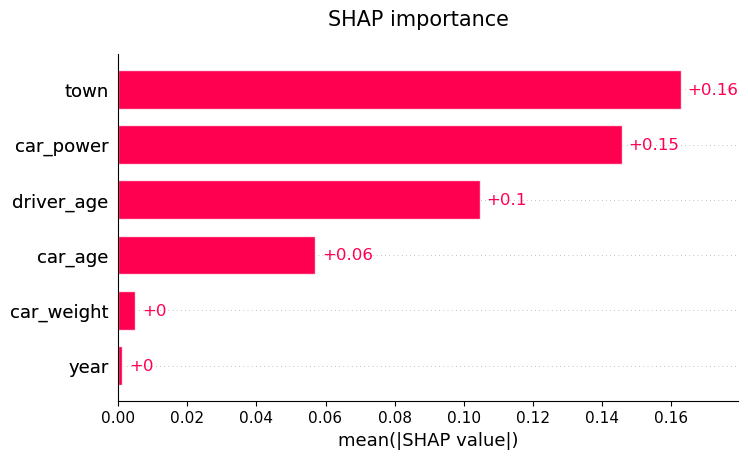

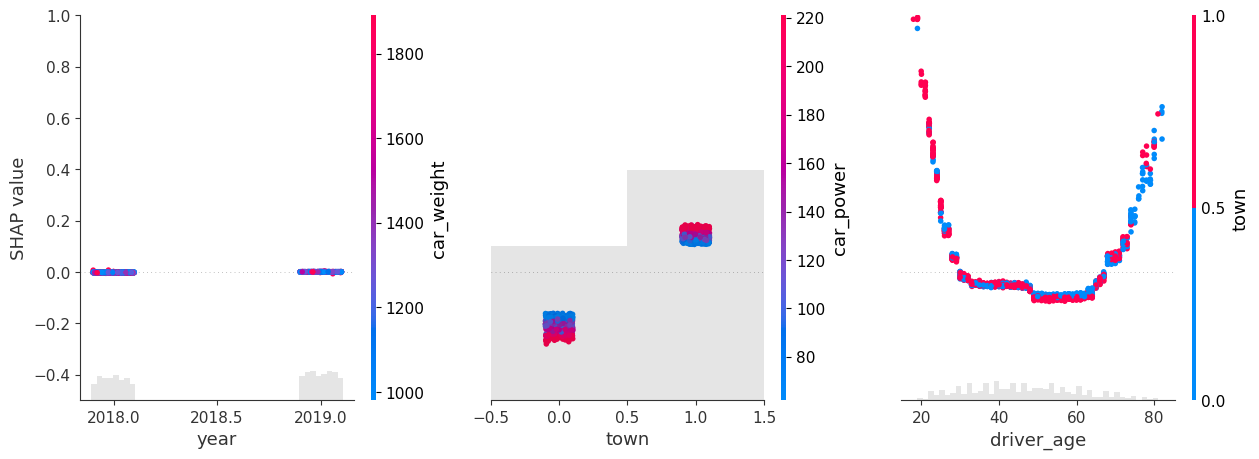

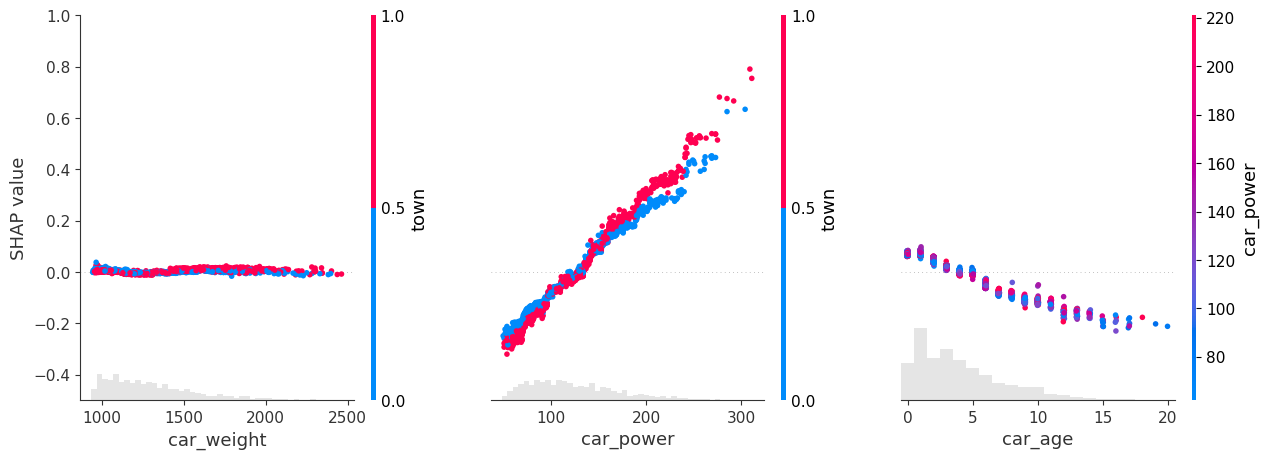

In [79]:
import shap

X_explain = X_train.sample(n=2000, random_state=937)
explainer = shap.Explainer(model)
shap_val = explainer(X_explain)

plt.suptitle("SHAP importance", fontsize=15)
shap.plots.bar(shap_val)

# Aweful API..., plots should be smaller, ax argument should work properly etc.
for s in [shap_val[:, 0:3], shap_val[:, 3:]]:
    shap.plots.scatter(s, color=shap_val, ymin=-0.5, ymax=1)

## Interaction constraints

Let's reduce the number of interactions!

- Specify: What features are allowed to interact, i.e., appear in same branch?
- In our model: `interaction_constraints=[[0], [2], [5], [1, 3, 4]]`
  - Features 0, 2, 5 are additive (no interactions).
  - Features 1, 3, 4 may interact.
- Available for LightGBM, XGBoost, HistGradientBoosting.
- Additivity -> PDP ~ centered ICE ~ SHAP dependence
- To be additive in all features, set `max_depth = 1` instead.

*Question:* How to make model with some features modeled additively and some with pairwise interactions?

### Let's implement above example

- For simplicity, use same hyper-parameters. 
- In practice, more boosting rounds required to compensate for suppressed interactions.

In [80]:
params_ic = params | {"interaction_constraints": [[0], [2], [5], [1, 3, 4]]}  # Mind the positions...
params_ic

{'learning_rate': 0.05,
 'objective': 'poisson',
 'metric': 'poisson',
 'num_leaves': 7,
 'min_child_samples': 50,
 'min_child_weight': 0.001,
 'colsample_bynode': 0.8,
 'subsample': 0.8,
 'reg_alpha': 3,
 'reg_lambda': 5,
 'verbose': -1,
 'interaction_constraints': [[0], [2], [5], [1, 3, 4]]}

In [81]:
model_ic = LGBMRegressor(n_estimators=num_rounds, **params_ic)
_ = model_ic.fit(X_train, y_train)

### SHAP dependence

- No vertical scatter visible anymore. Constraints seem to work.
- Dependence plots can be read "ceteris paribus".
- Additive features exactly described by SHAP dependence.

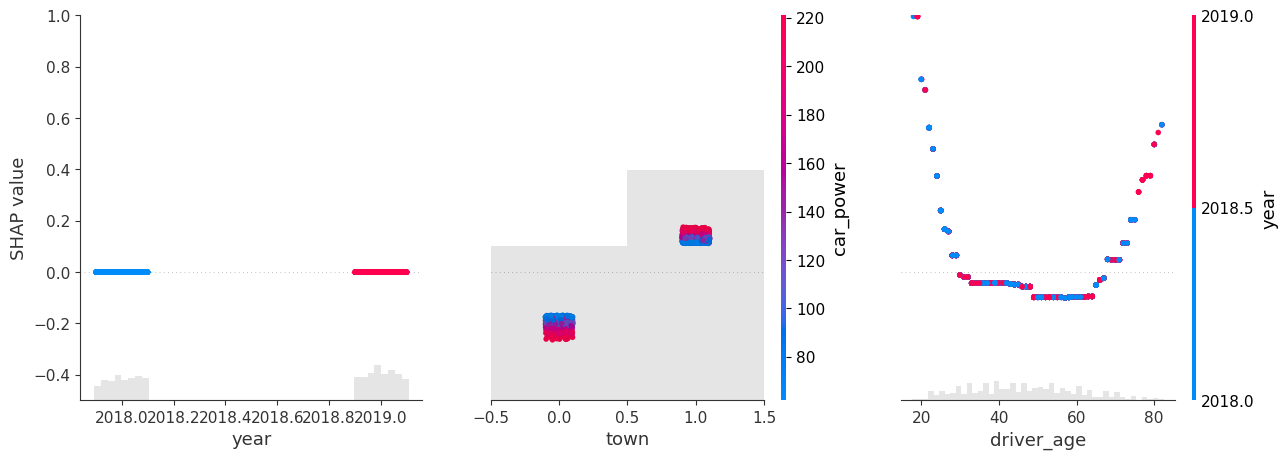

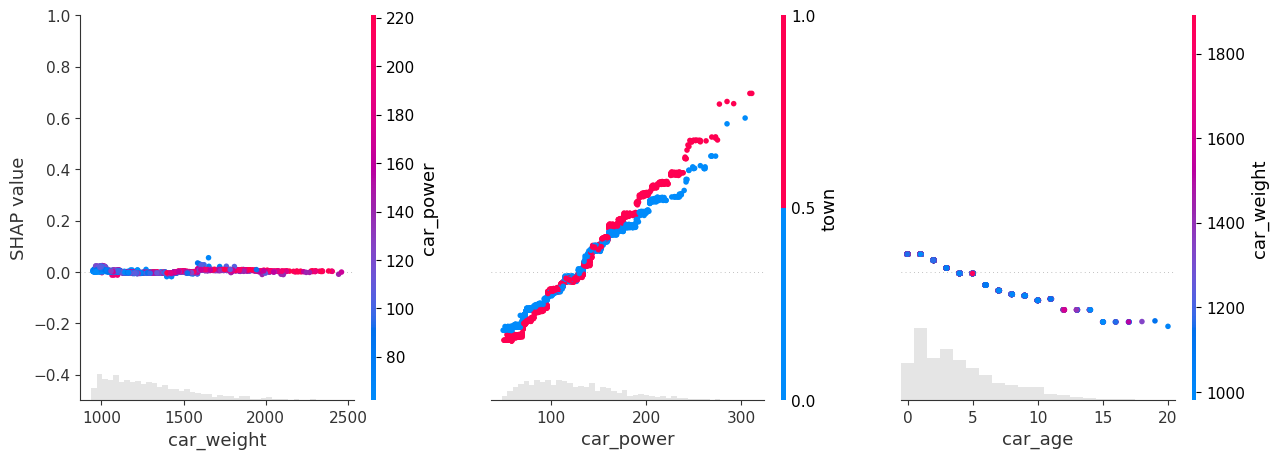

In [82]:
explainer_ic = shap.Explainer(model_ic)
shap_val_ic = explainer_ic(X_explain)

for s in [shap_val_ic[:, 0:3], shap_val_ic[:, 3:]]:
    shap.plots.scatter(s, color=shap_val_ic, ymin=-0.5, ymax=1)

### PDP and ICE

- PDP and ICE agree with SHAP dependence plot (up to vertical shift).
- Here, on log scale (due to Poisson loss). We define log-prediction class.

In [83]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.utils.validation import check_is_fitted


class LogRegressor(RegressorMixin):
    """
    A wrapper class for a Scikit-Learn regressor that evaluates predictions on a log scale.

    Parameters
    ----------
    regressor : object
        A Scikit-Learn regressor object that has already been fit to data.
    
    Methods
    -------
    predict(X)
        Make predictions for the given input data X.

    fit(*args, **kwargs)
        Not used.
    """
    def __init__(self, estimator):
        self._estimator = estimator
        check_is_fitted(self._estimator)
        self.is_fitted_ = True

    def fit(self, *args, **kwargs):
        return self

    def predict(self, X):
        return np.log(self._estimator.predict(X))

Similar insights with PDP and ICE. Parallel ICE curves mean additivity.

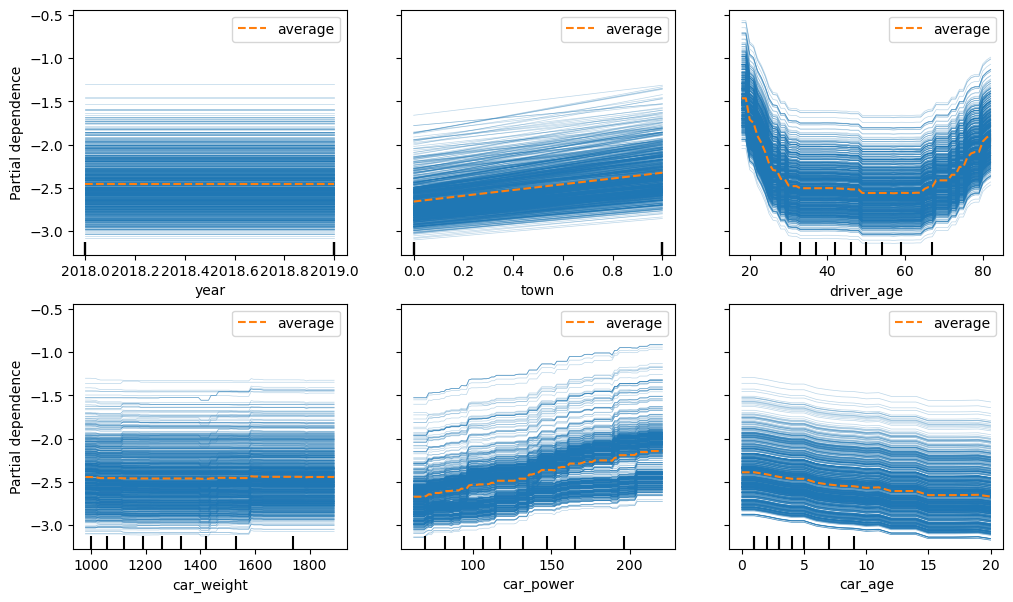

In [84]:
from sklearn.inspection import PartialDependenceDisplay

fig, axes = plt.subplots(2, 3, figsize=(12, 7))

_ = PartialDependenceDisplay.from_estimator(
    LogRegressor(model_ic), 
    X=X_explain, 
    features=X_explain.columns, 
    kind="both", 
    ax=axes
)

## Monotone constraints

Let's make predictions monotonic in feature $X_j$, ceteris paribus.

Implementation has two parts:
1. Splits on $X_j$ are done only if constraint not violated.
2. What about subsequent splits? (TODO: Add more spice)

The ICE curves of `car_power` and `car_age` are *almost* monotonic. Even if it does not make 100% sense, we will now model them *perfectly* monotonic.

**Be cautious:** Only if monotonicity is natural *ceteris paribus*. Counter-example?

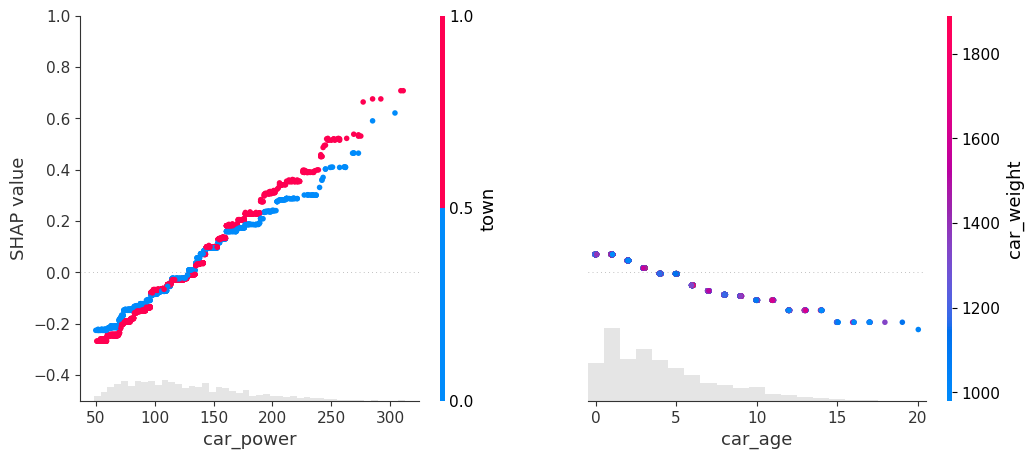

In [75]:
params_mc = params_ic | {"monotone_constraints": [0, 0, 0, 0, 1, -1]}  # Mind the positions...

model_mc = LGBMRegressor(n_estimators=num_rounds, **params_mc)
model_mc.fit(X_train, y_train)

# SHAP analysis
explainer_mc = shap.Explainer(model_mc)
shap_val_mc = explainer_mc(X_explain)

shap.plots.scatter(shap_val_mc[:, [4, 5]], color=shap_val_mc, ymin=-0.5, ymax=1)

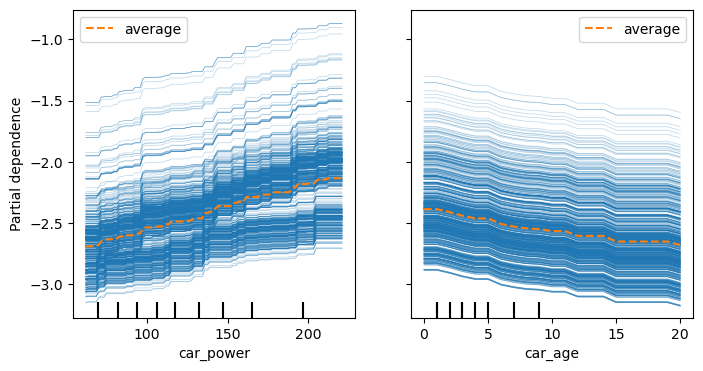

In [76]:
fig, axes = plt.subplots(figsize=(8, 4))

_ = PartialDependenceDisplay.from_estimator(
    LogRegressor(model_mc), X_explain, ["car_power", "car_age"], kind="both", ax=axes
)

**Comments** 

- Perfect monotonicity visible in SHAP plots only for *additive* features.
- Otherwise, monotonicity can be masked by interaction effects.
- But: PDP and ICE curves *are* perfectly monotonic (with or without interactions), see below.

## Monotonic constraints gone wrong

Define them correctly!

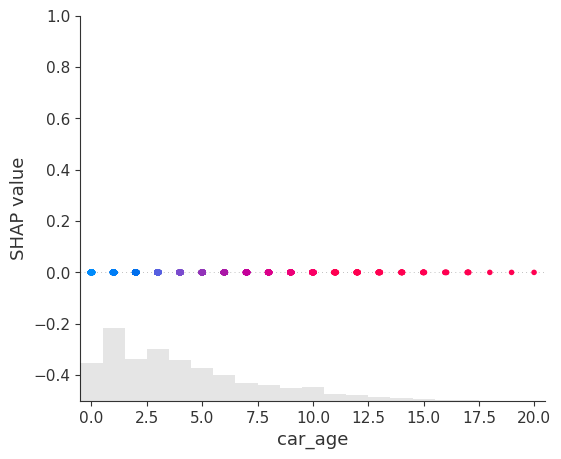

In [72]:
params_mc2 = params_ic | {"monotone_constraints": [0, 0, 0, 0, 1, 1]}  # Oops

model_mc2 = LGBMRegressor(n_estimators=num_rounds, **params_mc2)
model_mc2.fit(X_train, y_train)

explainer_mc2 = shap.Explainer(model_mc2)
shap_val_mc2 = explainer_mc2(X_explain)

shap.plots.scatter(shap_val_mc2[:, [5]], color=shap_val_mc2, ymin=-0.5, ymax=1)